In [254]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, accuracy_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [187]:
#Goals are only accounted in the leauge not outside competitions
#taking all players with at least one goal and predicting # of goals of a given player given
#Columns to consider: pos,squad,age, MP, starts, Min, asst, PK, PKatt, xAG
raw_data = pd.read_excel("../top5-players24-25.xlsx")
raw_data = raw_data.drop("Rk",axis=1)
df = raw_data[["Player","Pos","Squad","Age","MP","Starts","Min","Gls","Ast","PK","PKatt","xAG"]]
num_cols = df[["Age","MP","Starts","Min","Gls","Ast","PK","PKatt","xAG"]]
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df

/var/folders/mx/4qcb2ycx00b56p885wrfvpk40000gn/T/ipykernel_9393/299103339.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_numeric(df[col], errors='coerce')


,Player,Pos,Squad,Age,MP,Starts,Min,Gls,Ast,PK,PKatt,xAG
0,Max Aarons,DF,Bournemouth,24.0,3,1,86,0,0,0,0,0.0
1,Max Aarons,"DF,MF",Valencia,24.0,4,1,120,0,0,0,0,0.0
2,Rodrigo Abajas,DF,Valencia,21.0,1,1,65,0,0,0,0,0.0
3,James Abankwah,"DF,MF",Udinese,20.0,6,0,88,0,0,0,0,0.0
4,Keyliane Abdallah,FW,Marseille,18.0,1,0,3,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2849,Edhy Zuliani,DF,Toulouse,19.0,1,0,9,0,0,0,0,0.0
2850,Szymon Żurkowski,MF,Empoli,26.0,5,0,106,0,0,0,0,0.0
2851,Martin Ødegaard,MF,Arsenal,25.0,30,26,2325,3,8,1,1,5.4
2852,Milan Đurić,FW,Monza,34.0,18,13,1270,4,1,0,0,1.1


In [188]:
#Data Cleaning
#Have to remove names :(
df.drop(["Player"],axis=1,inplace=True)
df.dropna(inplace=True)
df.head()

/var/folders/mx/4qcb2ycx00b56p885wrfvpk40000gn/T/ipykernel_9393/4218148291.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(["Player"],axis=1,inplace=True)
/var/folders/mx/4qcb2ycx00b56p885wrfvpk40000gn/T/ipykernel_9393/4218148291.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


,Pos,Squad,Age,MP,Starts,Min,Gls,Ast,PK,PKatt,xAG
0,DF,Bournemouth,24.0,3,1,86,0,0,0,0,0.0
1,"DF,MF",Valencia,24.0,4,1,120,0,0,0,0,0.0
2,DF,Valencia,21.0,1,1,65,0,0,0,0,0.0
3,"DF,MF",Udinese,20.0,6,0,88,0,0,0,0,0.0
4,FW,Marseille,18.0,1,0,3,0,0,0,0,0.0


In [189]:
#selecting only players that have goals
df = df[df["Gls"]>0]
#giving numerical encoding to positions
unique = df["Pos"].unique()
pos_dict = {}
j = 1
for i in unique:
    pos_dict[i] = j
    j += 1
df["Pos"] = df["Pos"].map(pos_dict)
df.tail()

/var/folders/mx/4qcb2ycx00b56p885wrfvpk40000gn/T/ipykernel_9393/2117006691.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Pos"] = df["Pos"].map(pos_dict)


,Pos,Squad,Age,MP,Starts,Min,Gls,Ast,PK,PKatt,xAG
2844,2,Cagliari,25.0,35,33,2713,6,2,0,0,2.4
2848,6,Real Sociedad,25.0,36,33,2962,2,1,0,0,1.1
2851,6,Arsenal,25.0,30,26,2325,3,8,1,1,5.4
2852,4,Monza,34.0,18,13,1270,4,1,0,0,1.1
2853,4,Parma,34.0,9,3,268,1,0,0,0,0.0


In [190]:
df = df.drop("Squad",axis=1)

In [276]:
#split into training and test set
X = df.drop("Gls",axis=1)
Y = df["Gls"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=random.randint(1,100))
X_train.head()

,Pos,Age,MP,Starts,Min,Ast,PK,PKatt,xAG
1256,4,27.0,17,6,608,0,0,0,0.7
332,5,22.0,12,3,356,1,0,0,1.1
268,1,27.0,32,18,1598,1,0,0,1.2
940,2,23.0,33,25,2314,5,0,0,4.2
2820,4,33.0,7,7,587,0,0,0,0.5


In [277]:
#fit to regression model
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)

#Mean Error (not good for directionless errors)
sum(y_test-y_pred)/len(y_test)

-0.09106600858979999

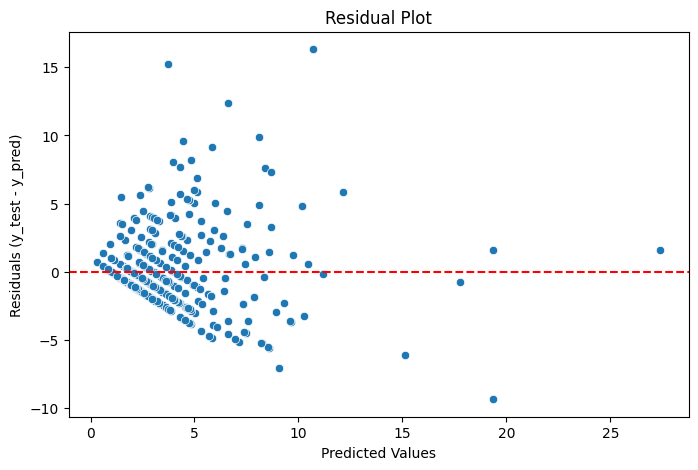

Residuals range:  [-9.345765454650543, 16.320801541618795]


In [291]:
residuals = y_test - y_pred

# Plot
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (y_test - y_pred)")
plt.title("Residual Plot")
plt.show()
print("Residuals range: ",[min(residuals),max(residuals)])

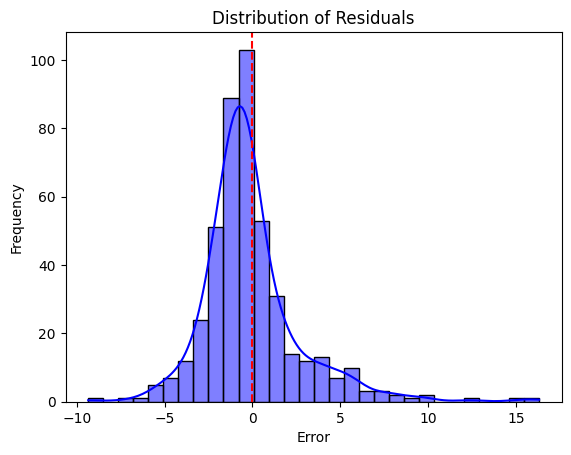

In [279]:
sns.histplot(residuals, kde=True, bins=30, color='blue')
plt.title("Distribution of Residuals")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.axvline(0, color='red', linestyle='--')
plt.show()

In [280]:
#Evaluate Model
print("R^2 Score:", lr.score(X_test, y_test))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

R^2 Score: 0.48493812891881705
RMSE: 2.777070669067542


In [281]:
#try implementing coss validation

# Use 5 folds (can increase to 10 for more granularity)
kf = KFold(n_splits=5, shuffle=True, random_state=random.randint(1,100))

# Define RMSE scorer (negative MSE because cross_val_score minimizes score)
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

In [282]:
#new model applying cross validation
lr2 = LinearRegression()
mse_scores = cross_val_score(lr2, X_train, y_train, cv=kf, scoring=rmse_scorer)
rmse_scores = np.sqrt(-mse_scores)

print("RMSE scores for each fold:", rmse_scores)
print("Average RMSE:", rmse_scores.mean())

RMSE scores for each fold: [2.2511506  2.64781359 2.70109851 2.43186818 2.79863127]
Average RMSE: 2.5661124301857132


In [283]:
lr2.fit(X_train,y_train)
y_pred_cv = lr2.predict(X_test)

#Evaluate Model
print("R^2 Score:", lr.score(X_test, y_test))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

R^2 Score: 0.48493812891881705
RMSE: 2.777070669067542


In [284]:
#Trying Random Forest because linear Regression score sucks
model = RandomForestRegressor(n_estimators=100, random_state=random.randint(1,100))
model.fit(X_train, y_train)

RandomForestRegressor(random_state=15)

In [285]:
y_pred_rf = model.predict(X_test)
print("R^2 Score:", model.score(X_test, y_test))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))

R^2 Score: 0.595273581748847
RMSE: 2.461716336507635


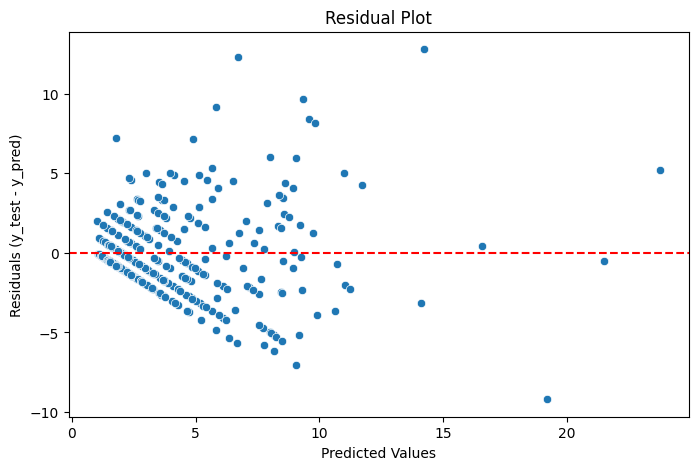

In [286]:
#Plotting final results from random forest
residuals_rf = y_test - y_pred_rf

# Plot
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred_rf, y=residuals_rf)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (y_test - y_pred)")
plt.title("Residual Plot")
plt.show()

In [290]:
print("Residuals range: ",[min(residuals_rf),max(residuals_rf)])

Residuals range:  [-9.190000000000001, 12.78]
